In [1]:
#import required libraries
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick

In [2]:
#define database
db = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'Xguard220!'
)

print(db)

In [3]:
def run_query(query, database):
    '''Run MySQL query, return query results as a dataframe with labelled columns.'''
    
    cursor = database.cursor()
    
    cursor.execute(query)
    result = cursor.fetchall()
    
    num_fields = len(cursor.description)
    names = [i[0] for i in cursor.description]
    
    df = pd.DataFrame(result, columns = names)
    return df

In [4]:
#Select top 5 age groups with most cases
age_query = 'select Age_group, count(*) as cases from covid.ontario group by Age_Group order by cases desc limit 9;'

age = run_query(age_query, db)
age

,Age_group,cases
0,20s,44014
1,30s,33245
2,50s,30982
3,40s,30177
4,<20,27501
5,60s,19880
6,70s,10745
7,80s,9375
8,90s,5865


Text(0, 0.5, 'Total Cases')

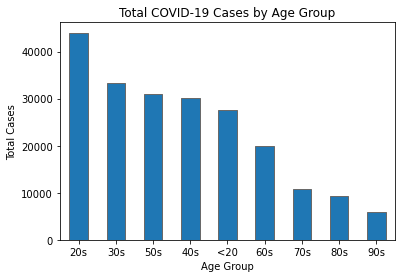

In [5]:
age.plot(kind = 'bar', x = 'Age_group', y = 'cases', legend = None, edgecolor = 'dimgrey')
plt.xticks(rotation = 0)
plt.title('Total COVID-19 Cases by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Cases')

In [6]:
death_query = '''select c.Age_Group, c.Client_Gender, c.cases, d.deaths, cast(((d.deaths / c.cases)*100) as decimal(8,6)) as death_rate 
from ( select Age_Group, Client_Gender, count(*) as cases
from covid.ontario group by Client_Gender, Age_Group) as c 
join
( select Age_Group, Client_Gender, count(*) as deaths from covid.ontario
where Outcome1 = 'Fatal' group by Client_Gender, Age_Group) as d
on c.Age_Group = d.Age_Group and c.Client_Gender = d.Client_Gender
order by death_rate desc;'''

deaths = run_query(death_query, db)
deaths

,Age_Group,Client_Gender,cases,deaths,death_rate
0,90s,MALE,1515,532,35.115512
1,90s,UNSPECIFIED,61,17,27.868852
2,90s,FEMALE,4289,1056,24.621124
3,80s,MALE,3536,850,24.038462
4,80s,UNSPECIFIED,70,16,22.857143
5,80s,FEMALE,5769,923,15.999307
6,70s,MALE,5362,544,10.145468
7,70s,UNSPECIFIED,57,5,8.771930
8,,UNSPECIFIED,14,1,7.142857
9,70s,FEMALE,5325,347,6.516432


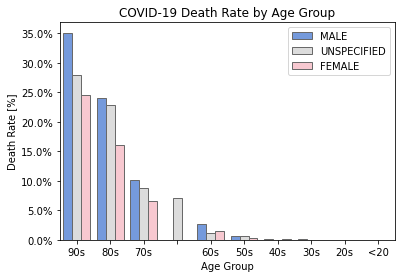

In [7]:
sns.barplot(x = 'Age_Group', y = 'death_rate', hue = 'Client_Gender', data = deaths, \
            palette = ['cornflowerblue', 'gainsboro', 'pink'], edgecolor = 'dimgrey')
plt.xticks(rotation = 0)
plt.title('COVID-19 Death Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Death Rate [%]')
plt.legend(loc = 'upper right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

In [9]:
pct_pop_query = '''select d.GEO_NAME, o.cases, d.population, o.cases / d.population * 100 as infection from
(select Reporting_PHU_City, count(*) as cases from covid.ontario group by Reporting_PHU_City) as o
join
(select GEO_NAME, sum(TOTAL_SEX) as population from covid.demographics 
where AGE_GROUP is not null and GEO_NAME in ('Windsor','Toronto','Guelph','Hamilton','Ottawa','Kingston')
group by GEO_NAME order by population desc limit 10) as d
on d.GEO_NAME = o.Reporting_PHU_City 
order by infection desc;'''

pct_pop = run_query(pct_pop_query, db)
pct_pop

,GEO_NAME,cases,population,infection
0,Windsor,9410,211680,4.4454
1,Toronto,66502,2665495,2.4949
2,Guelph,3149,128250,2.4554
3,Hamilton,7259,533680,1.3602
4,Ottawa,11189,908825,1.2312
5,Kingston,596,120690,0.4938


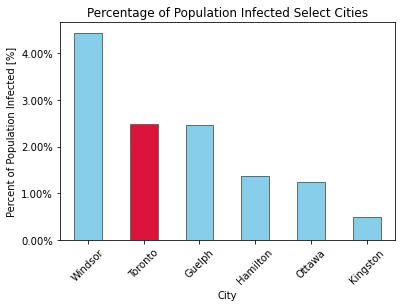

In [13]:
#convert decimals to floats
pct_pop.infection = [float(row) for row in pct_pop.infection]

colors = ['skyblue','crimson','skyblue','skyblue','skyblue']

pct_pop.plot(kind = 'bar', x = 'GEO_NAME', y = 'infection', legend = None, color = colors, edgecolor = 'dimgrey')
plt.xticks(rotation = 45)
plt.title('Percentage of Population Infected Select Cities')
plt.xlabel('City')
plt.ylabel('Percent of Population Infected [%]')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

In [11]:
pop_inf_query = '''select o.Age_Group, o.cases, d.population, o.cases / d.population * 100 as age_infection_rate from
(select Age_Group, count(*) as cases from covid.ontario 
group by Age_Group) as o
join
(select AGE_GROUP, sum(TOTAL_SEX) as population from covid.demographics 
where AGE_GROUP is not null
group by AGE_GROUP) as d
on d.AGE_GROUP = o.Age_Group 
order by age_infection_rate desc;'''

pop_inf = run_query(pop_inf_query, db)
pop_inf

,Age_Group,cases,population,age_infection_rate
0,90s,5865,62750,9.3466
1,20s,44014,1037760,4.2413
2,80s,9375,260435,3.5997
3,30s,33245,967550,3.4360
4,40s,30177,968935,3.1145
5,50s,30982,1057515,2.9297
6,60s,19880,787145,2.5256
7,70s,10745,463155,2.3200
8,<20,27501,1368115,2.0101


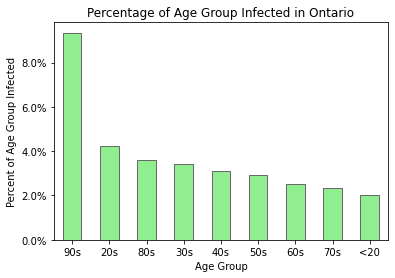

In [12]:
#convert decimals to floats
pop_inf.age_infection_rate = [float(row) for row in pop_inf.age_infection_rate]

pop_inf.plot(kind = 'bar', x = 'Age_Group', y = 'age_infection_rate', legend = None, color = 'lightgreen', edgecolor = 'dimgrey')
plt.xticks(rotation = 0)
plt.title('Percentage of Age Group Infected in Ontario')
plt.xlabel('Age Group')
plt.ylabel('Percent of Age Group Infected')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

In [18]:
trans_query = '''select Age_Group, Case_AcquisitionInfo, count(*) as cases from covid.ontario 
where Age_Group is not null and Age_Group <> '' and Age_Group <> 'UNKNOWN'
group by Age_Group, Case_AcquisitionInfo order by Age_Group, cases desc;'''

trans = run_query(trans_query, db)
trans.head()

,Age_Group,Case_AcquisitionInfo,cases
0,<20,CC,18398
1,<20,MISSING INFORMATION,3779
2,<20,NO KNOWN EPI LINK,2928
3,<20,OB,2184
4,<20,TRAVEL,193


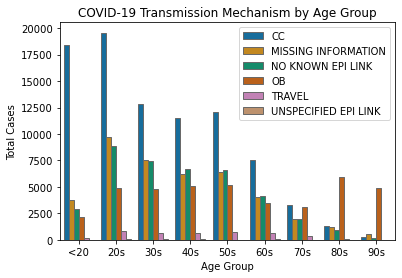

In [19]:
sns.barplot(x = 'Age_Group', y = 'cases', hue = 'Case_AcquisitionInfo', data = trans, \
            palette = 'colorblind', edgecolor = 'dimgrey')
plt.xticks(rotation = 0)
plt.title('COVID-19 Transmission Mechanism by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Cases')
plt.legend(loc = 'upper right')

In [24]:
#see population distribution for Ontario in general
on_pop_query = '''select AGE_GROUP, sum(TOTAL_SEX) / (select sum(TOTAL_SEX) from covid.demographics where AGE_GROUP is not null) * 100 as on_pct_pop 
from covid.demographics
where AGE_GROUP is not null
group by AGE_GROUP order by AGE_GROUP;'''

on_pop = run_query(on_pop_query, db)
on_pop

,AGE_GROUP,on_pct_pop
0,<20,19.6192
1,20s,14.8818
2,30s,13.8749
3,40s,13.8948
4,50s,15.1651
5,60s,11.2879
6,70s,6.6418
7,80s,3.7347
8,90s,0.8999


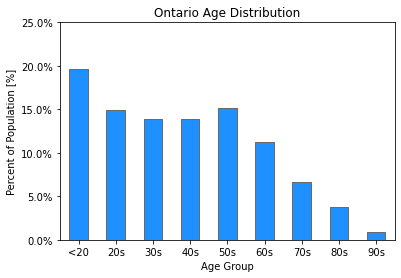

In [78]:
on_pop.on_pct_pop = [float(row) for row in on_pop.on_pct_pop]
on_pop.plot(kind = 'bar', x = 'AGE_GROUP', y = 'on_pct_pop', legend = None, color = 'dodgerblue', edgecolor = 'dimgrey')
plt.xticks(rotation = 0)
plt.title('Ontario Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Percent of Population [%]')
plt.ylim((0,25))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

In [5]:
#see population distributions for select major cities
pop_query = '''select a.GEO_NAME, a.AGE_GROUP, a.group_pop, t.city_pop, (a.group_pop / t.city_pop * 100) as pct_pop from
(select GEO_NAME, AGE_GROUP, sum(TOTAL_SEX) as group_pop from covid.demographics
where AGE_GROUP is not null and GEO_NAME in ('Windsor', 'Toronto', 'Guelph', 'Kingston')
group by GEO_NAME, AGE_GROUP order by GEO_NAME, AGE_GROUP) as a
left join
(select GEO_NAME, sum(TOTAL_SEX) as city_pop from covid.demographics
where AGE_GROUP is not null and GEO_NAME in ('Windsor', 'Toronto', 'Guelph', 'Kingston')
group by GEO_NAME order by city_pop desc) as t
on a.GEO_NAME = t.GEO_NAME
order by t.city_pop desc, a.GEO_NAME, a.AGE_GROUP;'''

pop = run_query(pop_query, db)
pop.head()

,GEO_NAME,AGE_GROUP,group_pop,city_pop,pct_pop
0,Toronto,<20,478360,2665495,17.9464
1,Toronto,20s,427695,2665495,16.0456
2,Toronto,30s,420890,2665495,15.7903
3,Toronto,40s,373315,2665495,14.0055
4,Toronto,50s,385210,2665495,14.4517


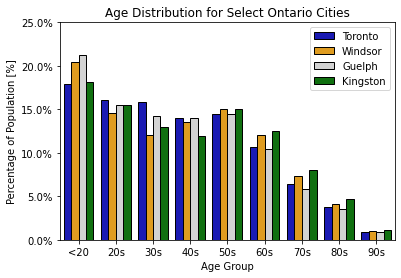

In [6]:
sns.barplot(x = 'AGE_GROUP', y = 'pct_pop', hue = 'GEO_NAME', data = pop,\
            palette = sns.color_palette(['mediumblue','orange','lightgray','g']), edgecolor = 'black')
plt.title('Age Distribution for Select Ontario Cities')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Population [%]')
plt.legend(loc = 'upper right')
plt.ylim((0,25))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

In [9]:
ts_query = '''select date_format(Case_Reported_Date, "%Y-%m") ym, Reporting_PHU_City, count(*) as cases 
from covid.ontario 
where Reporting_PHU_City in ('Windsor', 'Toronto', 'Guelph', 'Kingston') and year(Case_Reported_Date) = '2020'
group by Reporting_PHU_City, ym order by ym;'''

ts = run_query(ts_query, db)
ts.head()

,ym,Reporting_PHU_City,cases
0,2020-01,Toronto,2
1,2020-02,Toronto,6
2,2020-03,Toronto,834
3,2020-03,Kingston,46
4,2020-03,Windsor,92


Text(0, 0.5, 'Reported Cases')

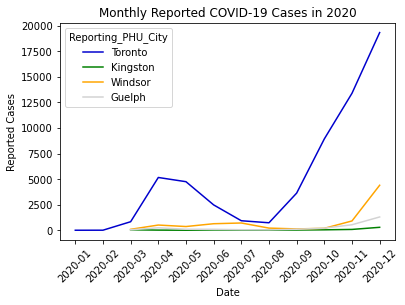

In [11]:
sns.lineplot(x = 'ym', y = 'cases', hue = 'Reporting_PHU_City', data = ts,\
             palette = sns.color_palette(['mediumblue','g','orange', 'lightgray']))
plt.xticks(rotation = 45)
plt.title('Monthly Reported COVID-19 Cases in 2020')
plt.xlabel('Date')
plt.ylabel('Reported Cases')

In [24]:
rep_gap_query = '''select date_format(Case_Reported_Date, "%Y-%m") as crd, date_format(Accurate_Episode_Date, "%Y-%m") as aed,
avg(datediff(Case_Reported_Date, Accurate_Episode_Date)) as avg_diff
from covid.ontario
group by crd
order by crd;'''

rep_gap = run_query(rep_gap_query, db)
rep_gap.head()

,crd,aed,avg_diff
0,2020-01,2020-01,0.7500
1,2020-02,2020-02,5.0714
2,2020-03,2020-03,7.2077
3,2020-04,2020-04,5.5245
4,2020-05,2020-04,6.6994


Text(0, 0.5, 'Average Days to Report Case')

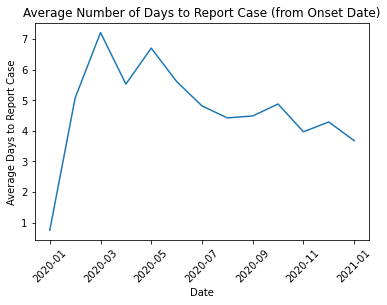

In [32]:
rep_gap.avg_diff = [float(row) for row in rep_gap.avg_diff]

rep_gap.plot(x = 'crd', y = 'avg_diff', legend = None)
plt.xticks(rotation = 45)
plt.title('Average Number of Days to Report Case (from Onset Date)')
plt.xlabel('Date')
plt.ylabel('Average Days to Report Case')

In [35]:
rep_gap_city_query = '''select Reporting_PHU_City, date_format(Case_Reported_Date, "%Y-%m") as crd, date_format(Accurate_Episode_Date, "%Y-%m") as aed,
avg(datediff(Case_Reported_Date, Accurate_Episode_Date)) as avg_diff
from covid.ontario
where Reporting_PHU_City in ('Toronto', 'Windsor', 'Guelph', 'Kingston')
group by Reporting_PHU_City, crd
order by crd;'''

rep_gap_city = run_query(rep_gap_city_query, db)
rep_gap_city.head()

,Reporting_PHU_City,crd,aed,avg_diff
0,Toronto,2020-01,2020-01,1.5000
1,Toronto,2020-02,2020-02,7.0000
2,Toronto,2020-03,2020-03,6.4952
3,Windsor,2020-03,2020-03,6.9239
4,Guelph,2020-03,2020-03,7.6458


Text(0, 0.5, 'Average Days to Report Case')

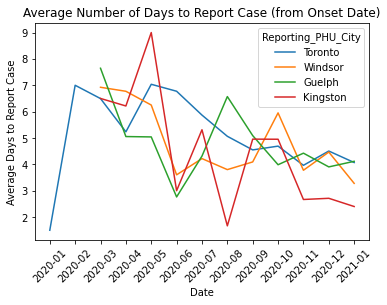

In [36]:
sns.lineplot(x = 'crd', y = 'avg_diff', hue = 'Reporting_PHU_City', data = rep_gap_city)
plt.xticks(rotation = 45)
plt.title('Average Number of Days to Report Case (from Onset Date)')
plt.xlabel('Date')
plt.ylabel('Average Days to Report Case')

In [45]:
rep_gap_age_query = '''select Age_Group, date_format(Case_Reported_Date, "%Y-%m") as crd, date_format(Accurate_Episode_Date, "%Y-%m") as aed,
avg(datediff(Case_Reported_Date, Accurate_Episode_Date)) as avg_diff
from covid.ontario
where Age_Group in ('20s','70s','80s','90s')
group by Age_Group, crd
order by crd;'''

rep_gap_age = run_query(rep_gap_age_query, db)
rep_gap_age.head()

,Age_Group,crd,aed,avg_diff
0,20s,2020-01,2020-01,0.0000
1,20s,2020-02,2020-02,16.0000
2,70s,2020-02,2020-02,7.0000
3,80s,2020-02,2020-02,8.0000
4,20s,2020-03,2020-03,7.0048


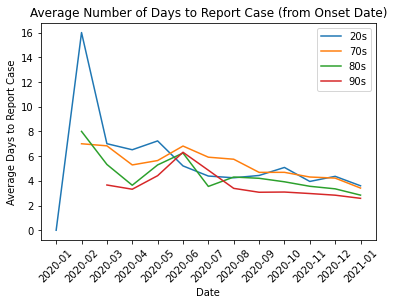

In [46]:
sns.lineplot(x = 'crd', y = 'avg_diff', hue = 'Age_Group', data = rep_gap_age)
plt.xticks(rotation = 45)
plt.title('Average Number of Days to Report Case (from Onset Date)')
plt.xlabel('Date')
plt.ylabel('Average Days to Report Case')
plt.legend(loc = 'upper right')